# Renangioblast

## Notebook to compute the RNA velocity analysis and create Fig. 6a-d 

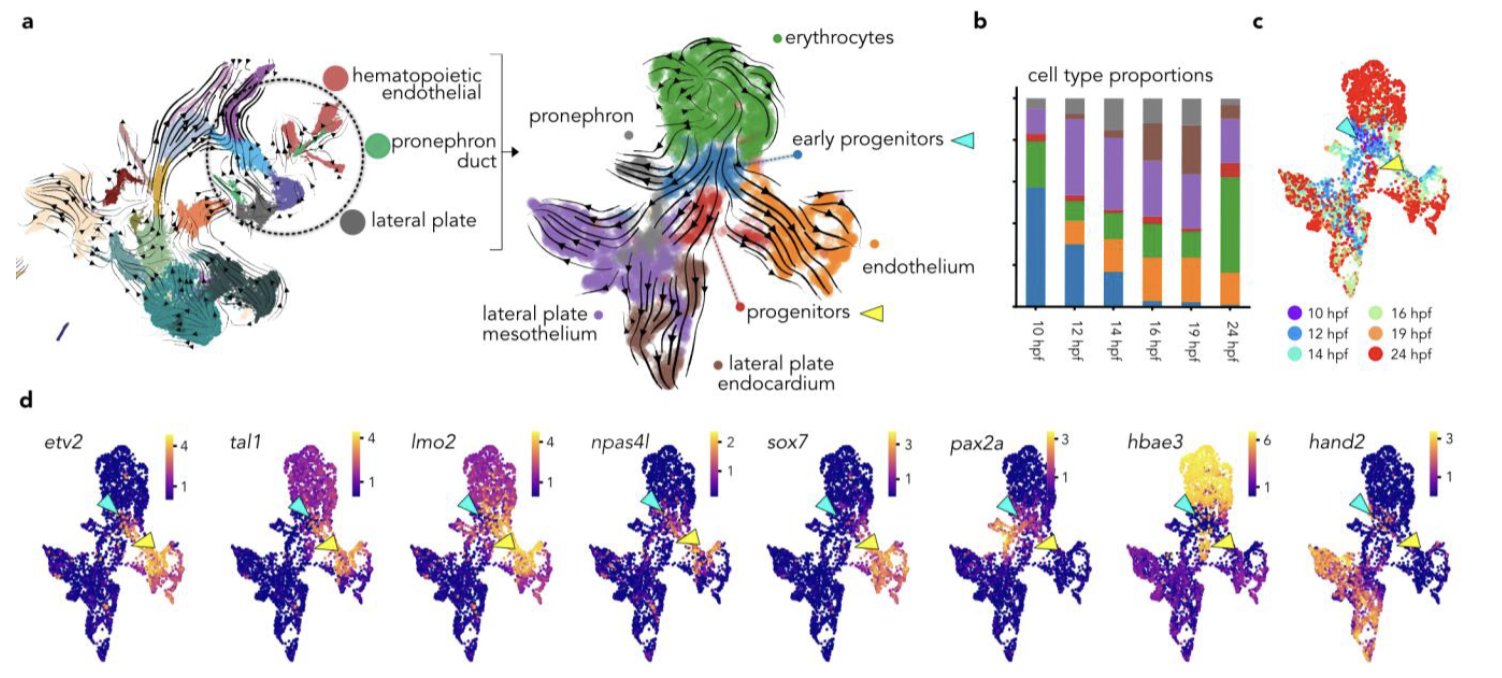

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scvelo as scv
import cellrank as cr

## Upload anndata objects, to get the RNA velocity counts and use the subset adata object for the renangioblast

In [3]:
bigadata = sc.read_h5ad('/home/sarah.ancheta/bruno1/projects/data.science/alejandro/danio-atlas/atlas_objects/velocity_objects/velocyto_Zebrahub_115k_cells.h5ad')

In [4]:
renan_adata = sc.read_h5ad('/home/sarah.ancheta/bruno1/projects/zebrahub/zebrahub_revision/scRNAseq/subset_renangioblast/alignUMAP_RNB/RNB_filtered_integrated_full_genes.h5ad')

## Prepare adata object: add cell type annotations and spliced/unspliced counts

In [5]:
def mergeVelocity(velo_adata, subset_adata):
    
    """
    Merges the velocity counts from the reference adata object with a 
    subset adata, using the cell_ids and umap of the subset.

    Parameters:
    velo_adata (anndata object): adata object from which to take the 
    counts, matrix, spliced, and unspliced to compute velocity 
    
    subset_adata (anndata object): adata object, a subset of the cells for which we want to run RNA velocity

    Returns:
    mini_subset: An adata object with the velocity counts transfered over from the full object, for the cells in the subset.

    """
    
    velo_list = velo_adata.obs.index.tolist()
    subset_list = subset_adata.obs.index.tolist()
    intersect_cells = list(filter(lambda x: x in velo_list, subset_list))
        
    # 1. subset according to the reference object 
    velo_subset_c  = velo_adata[velo_adata.obs.index.isin(intersect_cells)].copy()
    
    mini_subset_c = subset_adata[subset_adata.obs.index.isin(intersect_cells)].copy()
    velo_subset_c = velo_subset_c[mini_subset_c.obs_names].copy()

    # subset according to the overlapping genes

    vlist = velo_subset_c.var.index.tolist()
    slist = mini_subset_c.var.index.tolist()
    interlist_g = list(set(vlist) & set(slist))

    velo_subset  = velo_subset_c[:,velo_subset_c.var.index.isin(interlist_g)].copy()
    mini_subset  = mini_subset_c[:,mini_subset_c.var.index.isin(interlist_g)].copy()
    


    mini_subset.layers['counts'] = velo_subset.layers['counts'].copy()
    mini_subset.layers['matrix'] = velo_subset.layers['matrix'].copy()
    mini_subset.layers['spliced'] = velo_subset.layers['spliced'].copy()
    mini_subset.layers['unspliced'] = velo_subset.layers['unspliced'].copy()
    mini_subset.X = velo_subset.X.copy()
    
    return mini_subset 

In [6]:
test = mergeVelocity(bigadata, renan_adata)

Transfer cell type annotation column

In [7]:
adata = test.copy()

In [8]:
extra_adata = sc.read_h5ad('/home/sarah.ancheta/bruno1/projects/zebrahub/zebrahub_revision/scRNAseq/subset_renangioblast/scanpy/RNB_filtered_integrated_full_genes_V2.h5ad.h5ad')

In [9]:
extra_adata.obs[['leiden_1_annotated']]

,leiden_1_annotated
TDR44_TTTCCTCCAGCTGGTC-1,macrophages
TDR43_TGAATGCGTGCCTGAC-1,endothelial cells
TDR44_CCTAACCTCAAGGCTT-1,endothelial cells
TDR40_CACTAAGGTGGAGGTT-1,endothelial cells
TDR18_GCATGATCAGGAGGAG-1,pronephros - ICM
...,...
TDR39_AGTCACACAGGCTACC-1,intermediate cell mass of mesoderm mesothelium
TDR28_ATCATTCCAAGAGGTC-1,pronephros - ICM
TDR43_TAGTGCACAGCGTGAA-1,endothelial cells
TDR45_CCCTTAGAGGTTCTAC-1,RNB


In [10]:
adata.obs = adata.obs.join(extra_adata.obs['leiden_1_annotated'])

## UMAP plots colored by sample, cell type annotation, and timepoint

/home/sarah.ancheta/miniconda3/envs/vel38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


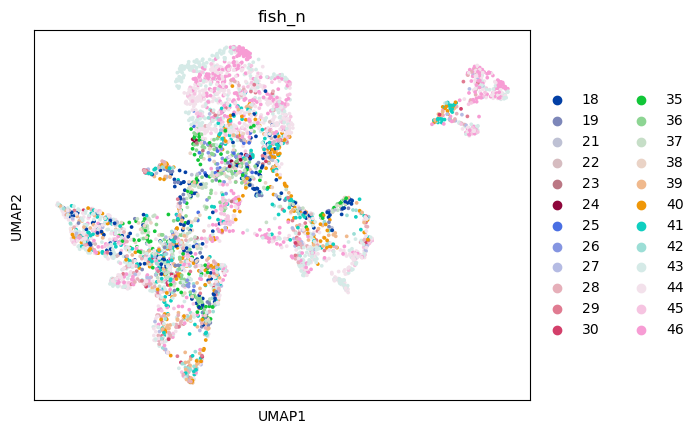

In [11]:
sc.pl.umap(adata, color='fish_n')

/home/sarah.ancheta/miniconda3/envs/vel38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


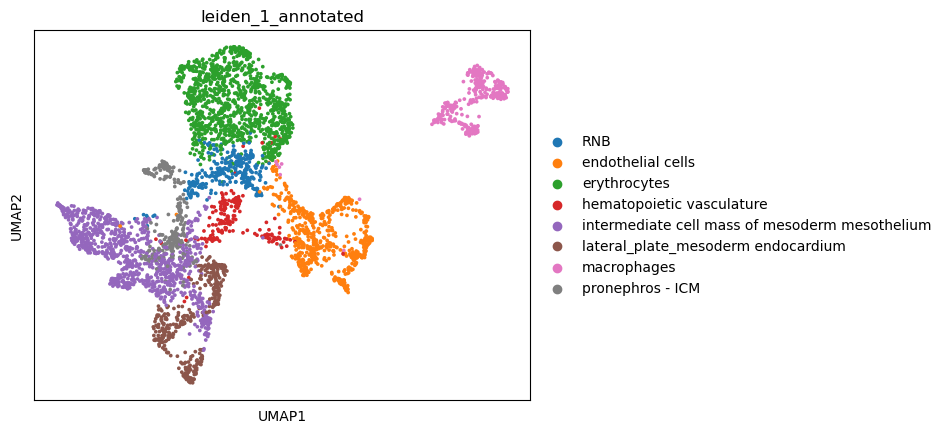

In [12]:
sc.pl.umap(adata, color='leiden_1_annotated')
plt.show()

Change timepoint labels

In [13]:
time_dict = {'0 budstage': '10 hpf', '05somite': '12 hpf', '10somite': '14 hpf', '15somite': '16 hpf', '20somite': '19 hpf', '30somite': '24 hpf'}

adata.obs['timepoint_hpf'] = adata.obs['timepoint'].map(time_dict)

In [14]:
custom_palette = {
    "10 hpf": "#9400D3",  # Electric Purple
    "12 hpf": "#007FFF",  # Electric Blue
    "14 hpf": "#00FFFF",  # Electric Cyan
    "16 hpf": "#00FF00",  # Electric Green
    "19 hpf": "#FFA500",  # Electric Orange
    "24 hpf": "#FF0000"   # Electric Red
}

/home/sarah.ancheta/miniconda3/envs/vel38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


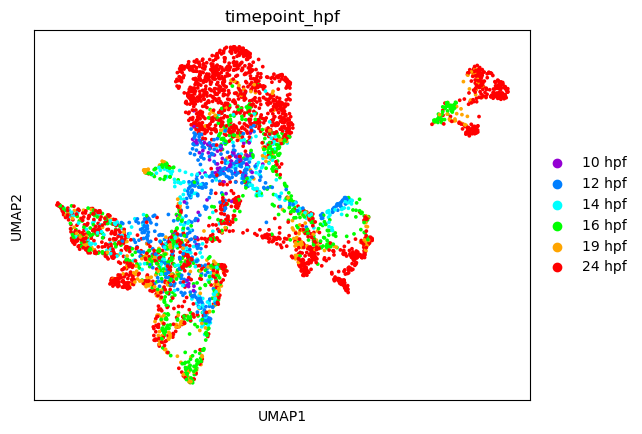

In [15]:
sc.pl.umap(adata, color='timepoint_hpf', palette=custom_palette, legend_loc = 'right margin')

## Run RNA velocity for renangioblast adata object

In [16]:
adata.X = adata.layers['counts'].copy()

In [17]:
def run_velocity(adata_obj, n_top_genes):
    
    """
    Runs scvelo stochastic on the adata object.

    Parameters:
    adata_obj (anndata object): adata object for which we will run scvelo stochastic
    
    n_top_genes (int): number of top genes to input in scvelo
    
    Returns:
    None, adata object now has added velocity information.
    
    """
    
    adata_obj.X = adata_obj.layers['counts'].copy()  # sc.velo uses unnormalized counts
    
    scv.pp.filter_and_normalize(adata_obj, min_shared_counts=20, n_top_genes=3000)
    scv.pp.moments(adata_obj, n_pcs=50, n_neighbors=30)
    
    scv.tl.velocity(adata_obj, mode='stochastic')
    
    
    scv.tl.velocity_graph(adata_obj)

In [18]:
run_velocity(adata, 3000)

Filtered out 10992 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/192 cores)


  0%|          | 0/4117 [00:00<?, ?cells/s]

/home/sarah.ancheta/miniconda3/envs/vel38zebra/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [19]:
celltype_palette = {
    "RNB": "#1f77b4",                                # Blue
    "endothelial cells": "#ff7f0e",                  # Orange
    "erythrocytes": "#2ca02c",                       # Green
    "hematopoietic vasculature": "#d62728",          # Red
    "intermediate cell mass of mesoderm mesothelium": "#9467bd",  # Purple
    "lateral_plate_mesoderm endocardium": "#8c564b", # Brown
    "macrophages": "#e377c2",                        # Pink
    "pronephros - ICM": "#7f7f7f"                    # Gray
}

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


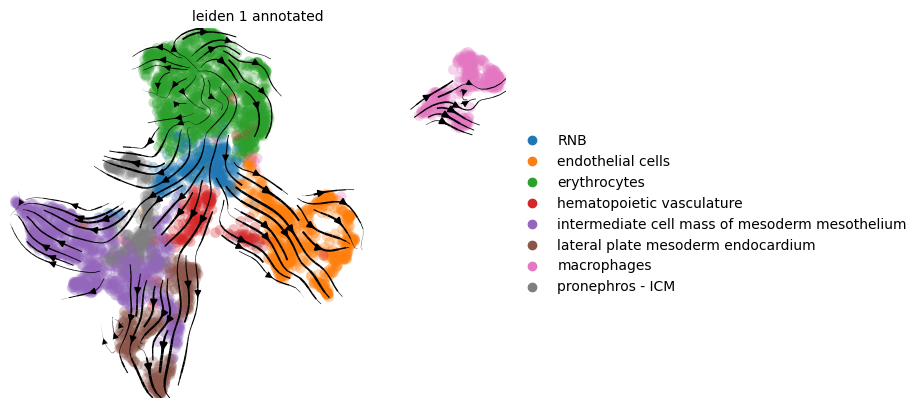

In [20]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color= 'leiden_1_annotated', palette=celltype_palette, legend_loc = 'right margin')


## UMAPs colored by gene expression

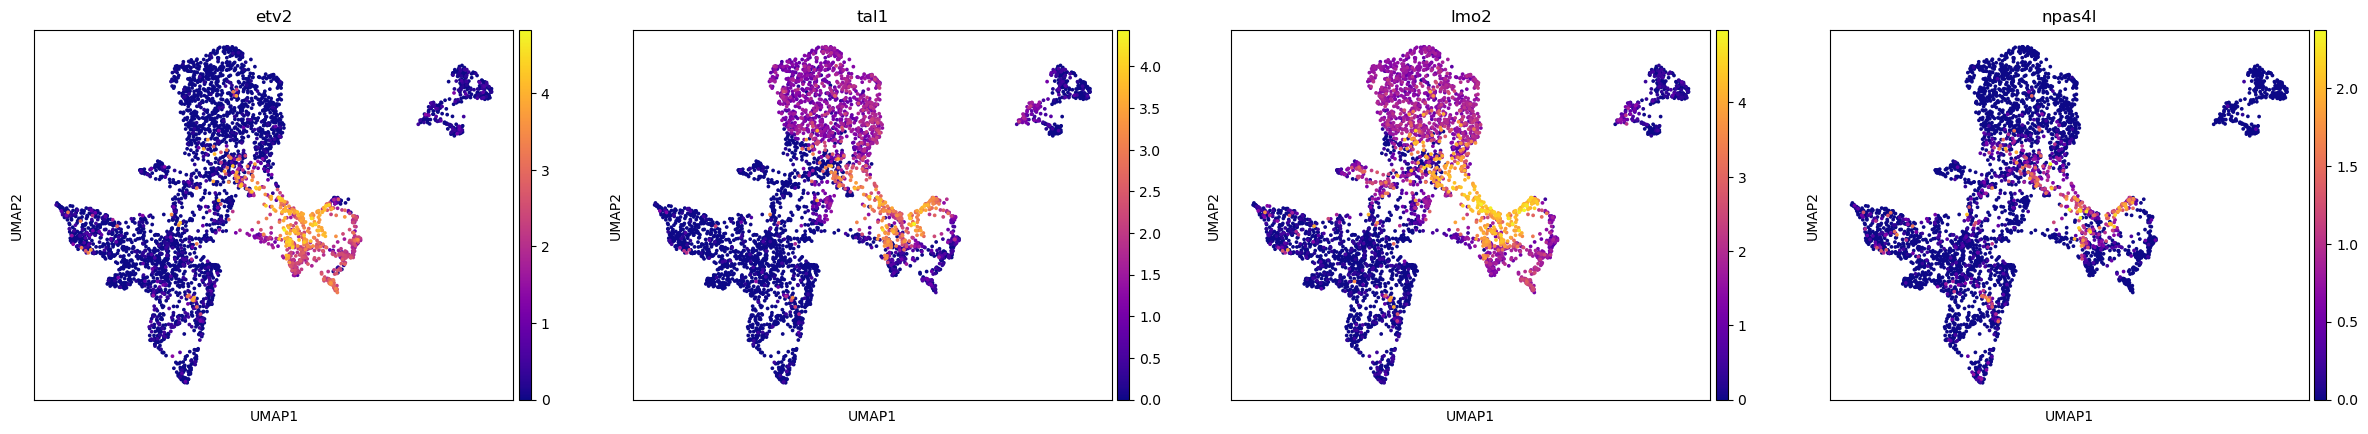

In [21]:
sc.pl.umap(adata, color=['etv2', 'tal1', 'lmo2', 'npas4l'], cmap='plasma')

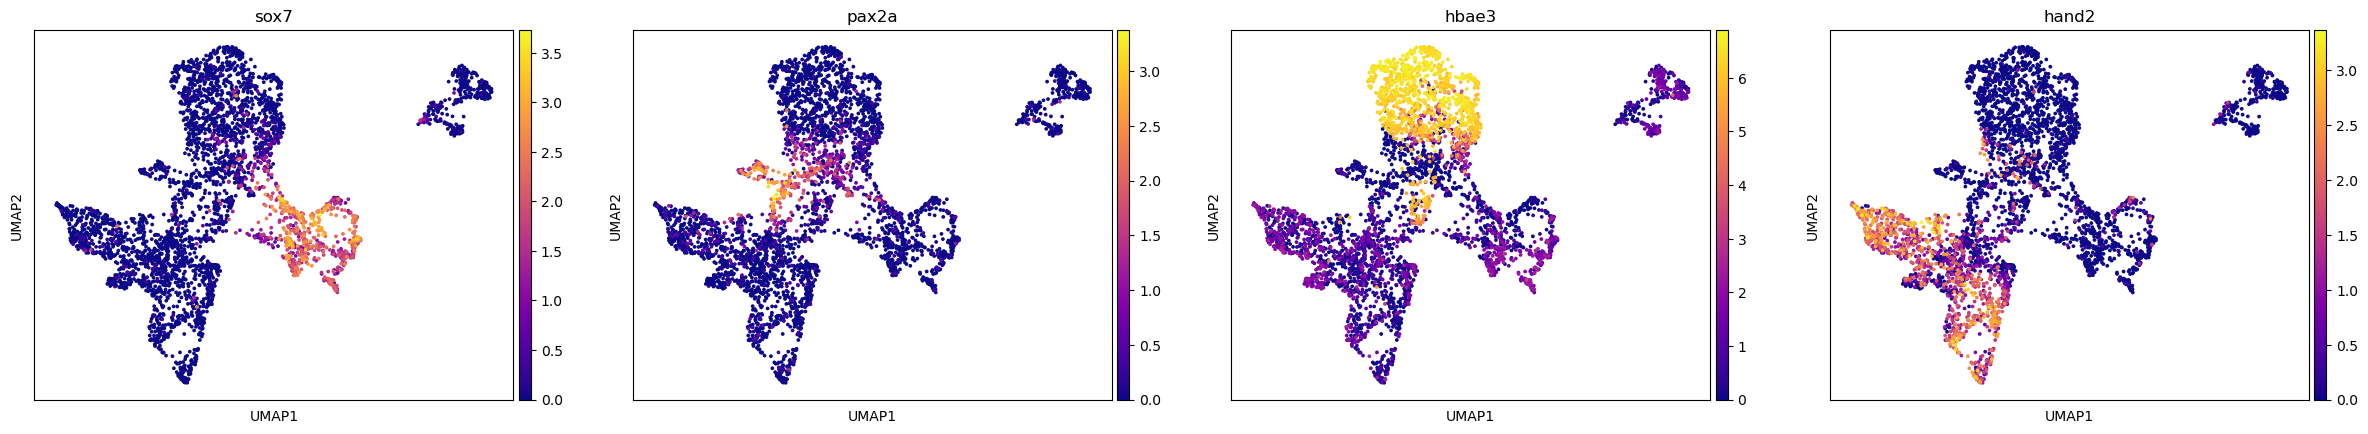

In [22]:
sc.pl.umap(adata, color=['sox7', 'pax2a', 'hbae3', 'hand2'], cmap='plasma')

## Stacked barplot with cell type fractions in renangioblast

In [23]:
def calculate_celltype_fractions(input_df, cell_types_of_interest, celltype, timepoint):
    
    """
    Creates a collapsed dataframe with the fraction of each cell type identified for each timepoint. The columns are
    timepoint and each of the cell types, with rows corresponding to the fraction of cells for each celltype within each timepoint.

    Parameters:
    input_df (pandas dataframe): the adata.obs information needed to compute the dataframe, ensuring the inclusion of the cell type 
    column and timepoint column.
    
    cell_types_of_interest (list of strings): a list of the cell types that should be included in the final dataframe, used to subset the full adata object.
    
    celltype (string): the name of the cell type column corresponding to the column in input_df
    
    timepoint: the name of the timepoint column corresponding to the column in timepoint
    
    Returns:
    fraction_df (pandas dataframe): including a timepoint column and columns for each cell type. the values include the fraction of
    cells that correspond to each celltype within the cells for that timepoint (as subset across the desired cell types).
    """
    
    # Filter the DataFrame to include only the desired cell types
    filtered_df = input_df[input_df[celltype].isin(cell_types_of_interest)]

    # Group by 'timepoint' and 'celltype' and count the occurrences
    counts = filtered_df.groupby([timepoint, celltype]).size().reset_index(name='count')

    # Pivot the DataFrame to have 'timepoint' as the index and cell types as columns
    pivoted_df = counts.pivot(index=timepoint, columns=celltype, values='count')

    # Fill NaN values with 0
    #pivoted_df.fillna(0, inplace=True)

    # Drop columns with all NaNs or 0s
    pivoted_df = pivoted_df.dropna(axis=1, how='all')
    pivoted_df = pivoted_df.loc[:, (pivoted_df != 0).any(axis=0)]
    
    # Calculate the total count for each timepoint
    total_counts = pivoted_df.sum(axis=1)

    # Calculate the fractions for each cell type
    fraction_df = pivoted_df.divide(total_counts, axis=0) * 100  # Multiply by 100 to get percentages

    # Reset the index and rename the columns
    fraction_df.reset_index(inplace=True)
    fraction_df.columns.name = None

    return fraction_df


In [25]:
adata

AnnData object with n_obs × n_vars = 4117 × 3000
    obs: 'seurat_clusters_res1.5', 'seqrun', 'leiden_v6_r0.32', 'leiden_v5_r0.35', 'annotation_seuratres1_5_v3', 'integrated_snn_res.0.5', 'orig.ident', 'fish_n', 'global_annotation', 'leiden_v11_r0.22', 'leiden_v4_r0.3', 'leiden_v3_r0.2', 'leiden_v10_r0.25', 'cell_annotation', 'fish', 'seurat_clusters', 'leiden_v2_r0.5', 'leiden_v12_r0.23', 'annotation_umapv2', 'annotation_umapv2_recluster', 'timepoint', 'leiden_v1_r1', 'leiden_v8_r0.31', 'X10X_run', 'annotation_umapv2_global', 'leiden_v9_r0.31', 'leiden_v7_r0.3', 'leiden', 'leiden_1_annotated', 'timepoint_hpf', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'mean', 'variance', 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'std', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'annotation_seuratres1_5_v3_colors', 'annotation_umapv2_colors',

In [26]:
input_df = adata.obs.copy()

In [27]:
input_df.leiden_1_annotated.unique()

['macrophages', 'endothelial cells', 'pronephros - ICM', 'intermediate cell mass of mesoderm mesothelium', 'erythrocytes', 'RNB', 'lateral_plate_mesoderm endocardium', 'hematopoietic vasculature']
Categories (8, object): ['RNB', 'endothelial cells', 'erythrocytes', 'hematopoietic vasculature', 'intermediate cell mass of mesoderm mesothelium', 'lateral_plate_mesoderm endocardium', 'macrophages', 'pronephros - ICM']

In [28]:
plot_df = calculate_celltype_fractions(input_df, ['endothelial cells', 'pronephros - ICM', 'intermediate cell mass of mesoderm mesothelium', 'erythrocytes', 'RNB', 'lateral_plate_mesoderm endocardium', 'hematopoietic vasculature'],
                        'leiden_1_annotated','timepoint_hpf')

In [29]:
plot_df

,timepoint_hpf,RNB,endothelial cells,erythrocytes,hematopoietic vasculature,intermediate cell mass of mesoderm mesothelium,lateral_plate_mesoderm endocardium,pronephros - ICM
0,10 hpf,57.317073,0.000000,21.951220,3.658537,12.195122,0.000000,4.878049
1,12 hpf,30.000000,11.276596,9.361702,2.765957,36.595745,2.553191,7.446809
2,14 hpf,16.768293,15.853659,12.500000,1.524390,34.451220,3.658537,15.243902
3,16 hpf,2.914110,20.858896,16.104294,3.527607,26.687117,17.944785,11.963190
4,19 hpf,2.493075,21.329640,12.465374,1.385042,26.038781,23.545706,12.742382
5,24 hpf,1.098326,15.481172,45.658996,6.956067,21.077406,6.694561,3.033473


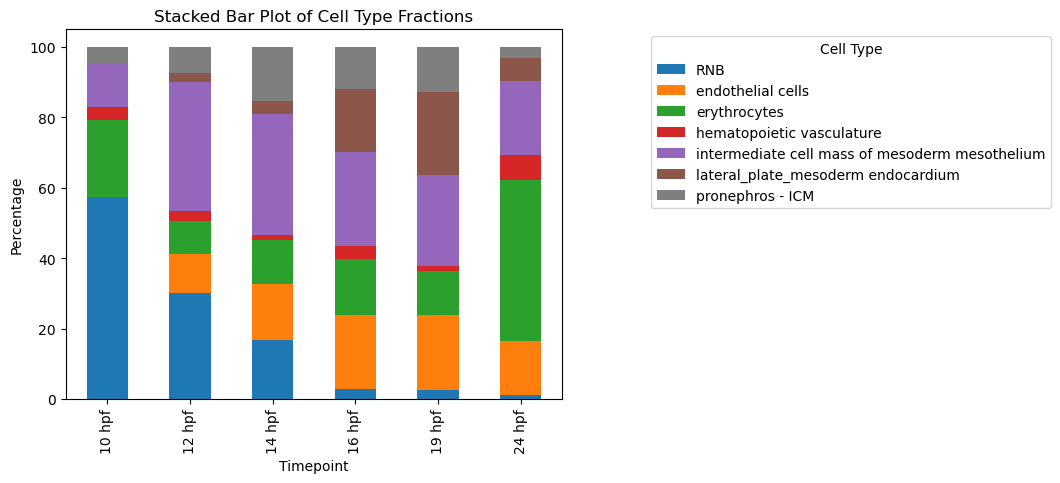

In [31]:
# Sort the DataFrame based on the 'timepoint' column in the desired order
timepoint_order = ['10 hpf', '12 hpf', '14 hpf', '16 hpf', '19 hpf', '24 hpf']
result_df = plot_df.set_index('timepoint_hpf').loc[timepoint_order].reset_index()

# Create a stacked bar plot with custom timepoint order
ax = result_df.plot(x='timepoint_hpf', kind='bar', stacked=True, 
                   color=[celltype_palette[col] for col in result_df.columns if col != 'timepoint_hpf'])

# Move the legend outside and to the upper right corner
ax.legend(title='Cell Type', loc='upper right', bbox_to_anchor=(2, 1))

plt.xlabel('Timepoint')
plt.ylabel('Percentage')
plt.title('Stacked Bar Plot of Cell Type Fractions')
plt.show()